# Segmenting and clustering neighborhoods in Toronto

## Introduction

In this project we explore, segment, and cluster the neighborhoods in the city of Toronto.
We scrape the Wikipedia page and wrangle the data, clean it and save it in pandas dataset.

We will scrape the Wikipedia page : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

We use the Foursquare API to explore Toronto neighbourhoods and get lots of information about toronto's neighbourhoods.

Finaly we use the KMeans algorithm to segment the neighborhoods.

# Part I

In [121]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from bs4 import BeautifulSoup
import json 
import requests # library to handle requests
import folium
from PIL import Image               # to load images
from IPython.display import display # to display images

In [32]:
# Source data
data_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text 
soup = BeautifulSoup(data_source, 'lxml')


In [33]:
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [34]:
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) 

In [35]:
# create a new DataFrame from the three lists
toronto = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

In [36]:
toronto.head()

,Borough,Neighborhood,PostalCode
0,Not assigned,Not assigned,M1A
1,Not assigned,Not assigned,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A


Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.

In [37]:
# Ignore cells with a borough that is Not assigned.
toronto = toronto[toronto.Borough != "Not assigned"]

In [38]:
toronto.reset_index(drop=True, inplace=True)
toronto.head()

,Borough,Neighborhood,PostalCode
0,North York,Parkwoods,M3A
1,North York,Victoria Village,M4A
2,Downtown Toronto,Harbourfront,M5A
3,North York,Lawrence Heights,M6A
4,North York,Lawrence Manor,M6A


In [39]:
toronto = toronto.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))

### let's replace 'Not assigned' neighborhoods with the name of the Borough

In [40]:
toronto.loc[toronto['Neighborhood'] == 'Not assigned', 'Neighborhood'] = toronto['Borough']

In [41]:
toronto.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


#### Let's verify no 'Not assigned' value in Neighborhood column

In [42]:
toronto[toronto['Neighborhood']=='Not assigned'].count()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [43]:
toronto.shape

(103, 3)

# End Part I


# Part II

In thit part we will built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

The second dataset is here :  http://cocl.us/Geospatial_data



## I use the cvs file with postalcodes provided

In [44]:
url2="http://cocl.us/Geospatial_data"
geo_toronto=pd.read_csv(url2,skiprows=1,names=['PostalCode','Latitude','Longitude'])
geo_toronto.head(10)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [45]:
geo_toronto.shape

(103, 3)

In [46]:
# merge two table on the column "PostalCode"
df_toronto = toronto.merge(geo_toronto,  how='inner', on='PostalCode')


In [50]:
df_toronto.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [51]:
df_toronto.shape

(103, 5)

# 103 rows by 5 columns

# End Part II

## Part III

I will use the Foursquare API to explore neighborhoods in selected cities in toronto and I will work with only boroughs that contain the word Toronto.

The Foursquare explore function will be used to get the most common venue categories in each neighborhood.
I use this features to group into clusters and use K-means cluster.
Fanally, I use the Folium library to visualize the Tornonto's neighborhoods.

I can't visualize map in github, you can use this link to see map :



### We explore and cluster the neighborhoods in Toronto

In [54]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### I use geopy to get the latitude and longitude of Toronto city.

In [55]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


#### I create map of Toronto

In [56]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,prefer_canvas=True)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
    df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

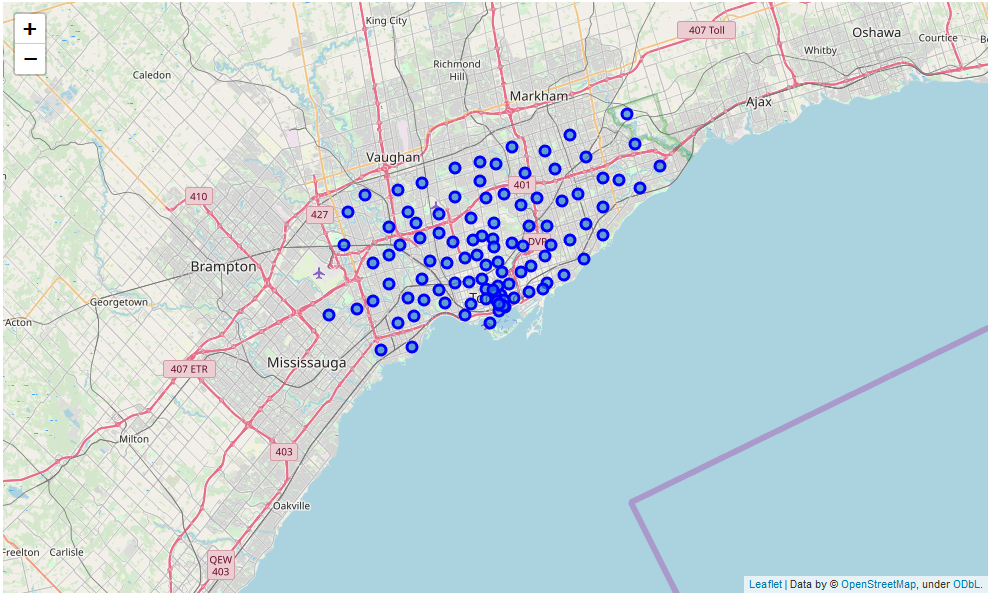

In [122]:
pil_im = Image.open('cap1.png')
display(pil_im)

#### I take juste the data where Borough contain the word Toronto

In [57]:
df_with_toronto= df_toronto[df_toronto['Borough'].str.contains('Toronto', na = False)].reset_index(drop=True)
df_with_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [58]:
# mb df_with_toronto.shape


(39, 5)

In [59]:
# mb borough_toronto = []

# mb for x in list(df_toronto.Borough.unique()):
# mb    if "toronto" in x.lower():
# mb        borough_toronto.append(x)
        
# mbborough_toronto

#### I create the map with new markers

In [60]:
# create map of Toronto 
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_with_toronto['Latitude'], df_with_toronto['Longitude'], 
    df_with_toronto['Borough'], df_with_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

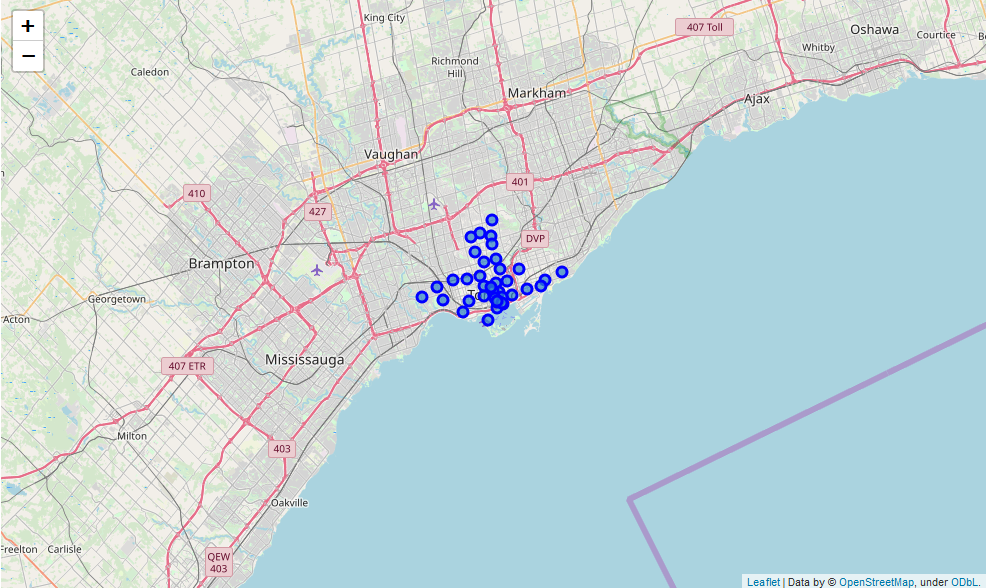

In [123]:
pil_im = Image.open('cap2.png')
display(pil_im)

In [ ]:
import getpass

CLIENT_ID = getpass.getpass('Enter your CLIENT_ID')
CLIENT_SECRET = getpass.getpass('Enter your CLIENT_ISECRET')

radius = 500
LIMIT = 100
VERSION = '20180604'

In [62]:
# Function by coursera
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### I retrieve all venues 

In [63]:
df_venues = getNearbyVenues(names=df_with_toronto['Neighborhood'],
                                   latitudes=df_with_toronto['Latitude'],
                                   longitudes=df_with_toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

#### Let's check the size of the resulting dataframe

In [64]:
print(df_venues.shape)
df_venues.head()

(1701, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Park,43.675278,-79.294647,Park
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


#### Let's check how many venues were returned for each neighborhood

In [65]:
df_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,56,56,56,56,56,56
"Brockton, Exhibition Place, Parkdale Village",25,25,25,25,25,25
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,83,83,83,83,83,83
"Chinatown, Grange Park, Kensington Market",80,80,80,80,80,80
Christie,18,18,18,18,18,18


#### Let's find out how many unique categories can be curated from all the returned venues

In [66]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 227 uniques categories.


First, let's write a function to sort the venues in descending order.

## Analyze Each Neighborhood

In [67]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [68]:
toronto_onehot.shape

(1701, 227)

### let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [69]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.02,0.0,0.0,0.000000,0.0,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.0300,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0000,0.01,0.0000,0.01,0.010000,0.000000,0.0,0.01,0.03,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.070000,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.00,0.03,0.0,0.000000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.02,0.0,0.0,0.01,0.0,0.01,0.000000,0.010000,0.00,0.02,0.010000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Let's confirm the new size

In [70]:
toronto_grouped.shape

(39, 227)

### Let's print each neighborhood along with the top 5 most common venues

In [71]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
             venue  freq
0      Coffee Shop  0.07
1  Thai Restaurant  0.04
2             Café  0.04
3       Steakhouse  0.04
4       Restaurant  0.03


----Berczy Park----
          venue  freq
0   Coffee Shop  0.09
1  Cocktail Bar  0.04
2          Café  0.04
3    Steakhouse  0.04
4        Bakery  0.04


----Brockton, Exhibition Place, Parkdale Village----
                   venue  freq
0                   Café  0.12
1  Performing Arts Venue  0.08
2            Coffee Shop  0.08
3              Nightclub  0.08
4         Breakfast Spot  0.08


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.06
2                   Spa  0.06
3  Gym / Fitness Center  0.06
4         Garden Center  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
                 venue  freq
0       Airport Lounge  0.12
1     A

### let's write a function to sort the venues in descending order.

In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [73]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Thai Restaurant,Steakhouse,Café,Cosmetics Shop,Bar,Asian Restaurant,Restaurant,Burger Joint,Bakery
1,Berczy Park,Coffee Shop,Cheese Shop,Steakhouse,Farmers Market,Beer Bar,Cocktail Bar,Bakery,Seafood Restaurant,Café,Restaurant
2,"Brockton, Exhibition Place, Parkdale Village",Café,Nightclub,Coffee Shop,Breakfast Spot,Performing Arts Venue,Yoga Studio,Climbing Gym,Bar,Bakery,Italian Restaurant
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Comic Shop,Pizza Place
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Terminal,Plane,Coffee Shop,Boutique,Boat or Ferry,Rental Car Location,Bar,Harbor / Marina,Sculpture Garden
5,"Cabbagetown, St. James Town",Coffee Shop,Pizza Place,Restaurant,Pub,Café,Italian Restaurant,Bakery,Caribbean Restaurant,Breakfast Spot,Butcher
6,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Juice Bar,Japanese Restaurant,Burger Joint,Ice Cream Shop,Salad Place,Bakery
7,"Chinatown, Grange Park, Kensington Market",Bar,Café,Coffee Shop,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Dessert Shop,Bakery
8,Christie,Grocery Store,Café,Park,Restaurant,Italian Restaurant,Baby Store,Gas Station,Candy Store,Coffee Shop,Nightclub
9,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Café,Fast Food Restaurant,Gastropub,Men's Store,Pub


# Cluster Neighborhoods

### let's search the best number of clusters

In [75]:
ks = range(1,20)
inertias = []
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(toronto_grouped_clustering)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    

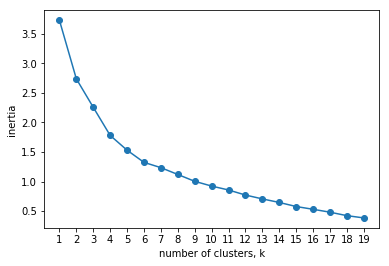

In [76]:
# Plot ks vs inertias
from matplotlib import pyplot as plt
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

#### I take 5 as number of cluster

In [77]:
# set number of clusters
kclusters = 5

# toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [79]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_with_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head(10) # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Park,Trail,Health Food Store,Pub,Cupcake Shop,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Dessert Shop,Diner,Spa,Pub
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Sandwich Place,Food & Drink Shop,Brewery,Liquor Store,Burger Joint,Burrito Place,Italian Restaurant,Pub,Fast Food Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Brewery,American Restaurant,Bakery,Latin American Restaurant,Pet Store,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,Park,Gym,Food & Drink Shop,Hotel,Convenience Store,Sandwich Place,Breakfast Spot,Department Store,Doner Restaurant,Dog Run
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,0,Coffee Shop,Clothing Store,Yoga Studio,Sporting Goods Shop,Furniture / Home Store,Health & Beauty Service,Fast Food Restaurant,Diner,Dessert Shop,Mexican Restaurant
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Coffee Shop,Dessert Shop,Sandwich Place,Pizza Place,Café,Italian Restaurant,Sushi Restaurant,Gym,Gourmet Shop,Indian Restaurant
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,2,Restaurant,Playground,Women's Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,0,Coffee Shop,Pub,Restaurant,Sushi Restaurant,Sports Bar,Pizza Place,Fried Chicken Joint,American Restaurant,Liquor Store,Vietnamese Restaurant


In [80]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
       4, 0, 2, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Final resulting clusters visualization

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters=5
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### We can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

## Cluster 1 (café)

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Park,Trail,Health Food Store,Pub,Cupcake Shop,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
1,East Toronto,0,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Furniture / Home Store,Yoga Studio,Dessert Shop,Diner,Spa,Pub
2,East Toronto,0,Park,Sandwich Place,Food & Drink Shop,Brewery,Liquor Store,Burger Joint,Burrito Place,Italian Restaurant,Pub,Fast Food Restaurant
3,East Toronto,0,Café,Coffee Shop,Gastropub,Italian Restaurant,Brewery,American Restaurant,Bakery,Latin American Restaurant,Pet Store,Seafood Restaurant
5,Central Toronto,0,Park,Gym,Food & Drink Shop,Hotel,Convenience Store,Sandwich Place,Breakfast Spot,Department Store,Doner Restaurant,Dog Run
6,Central Toronto,0,Coffee Shop,Clothing Store,Yoga Studio,Sporting Goods Shop,Furniture / Home Store,Health & Beauty Service,Fast Food Restaurant,Diner,Dessert Shop,Mexican Restaurant
7,Central Toronto,0,Coffee Shop,Dessert Shop,Sandwich Place,Pizza Place,Café,Italian Restaurant,Sushi Restaurant,Gym,Gourmet Shop,Indian Restaurant
9,Central Toronto,0,Coffee Shop,Pub,Restaurant,Sushi Restaurant,Sports Bar,Pizza Place,Fried Chicken Joint,American Restaurant,Liquor Store,Vietnamese Restaurant
11,Downtown Toronto,0,Coffee Shop,Pizza Place,Restaurant,Pub,Café,Italian Restaurant,Bakery,Caribbean Restaurant,Breakfast Spot,Butcher
12,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Café,Fast Food Restaurant,Gastropub,Men's Store,Pub



## Cluster 2 (Garden)

In [83]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,1,Garden,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store


## Cluster 3

In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,2,Restaurant,Playground,Women's Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store,Diner


## Cluster 4 (Jewelry and women's store)

In [85]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,3,Jewelry Store,Trail,Mexican Restaurant,Sushi Restaurant,Women's Store,Department Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


## Cluster 5 (Park, Playground and swim Scool) 

In [86]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Park,Swim School,Bus Line,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
10,Downtown Toronto,4,Park,Playground,Trail,Cupcake Shop,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store


In [118]:
map_clusters.save("cap3.html")

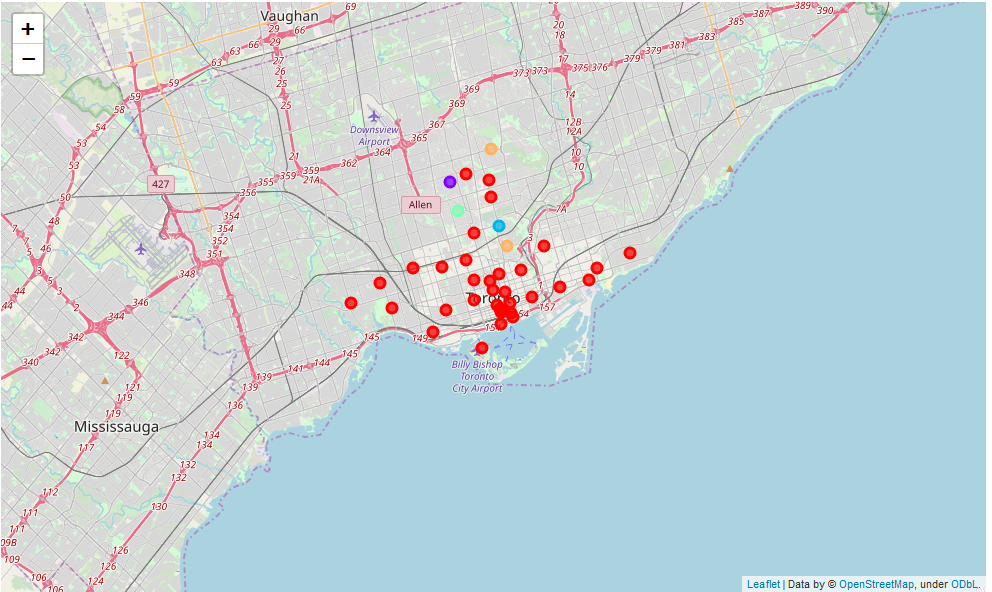

In [120]:
pil_im = Image.open('cap3.png')
display(pil_im)